In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=6a23f97299de1174ee534ad8f99fd93e0fc4546707f8d4d05d7077820bdac2fe
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.3 MB/s eta 0:00:00


In [3]:
pip install tqdm

In [4]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import ta  # Technical Analysis library
import shap
from sklearn.model_selection import train_test_split

In [6]:
# Load the dataset from Kaggle
file_path = '/content/drive/MyDrive/Data/SOL_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,open_time,open,high,low,close,volume
0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34
1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86
2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13
3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76
4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91


In [8]:
# open_time 열을 datetime 형식으로 변환
data['open_time'] = pd.to_datetime(data['open_time'])

# 시각과 분만 추출하여 time 열 생성
data['time'] = data['open_time'].dt.strftime('%H:%M')

# ATR 계산
atr_periods = [5, 10, 14, 20, 50]
for period in atr_periods:
    data[f'atr_{period}'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], window=period)

# VWAP 계산
data['vwap'] = ta.volume.volume_weighted_average_price(data['high'], data['low'], data['close'], data['volume'])

# Stochastic Oscillator 계산
stoch_periods = [(14, 3), (21, 5), (9, 3), (5, 2), (20, 7)]
for period, smooth in stoch_periods:
    data[f'stoch_%k_{period}_{smooth}'] = ta.momentum.stoch(data['high'], data['low'], data['close'], window=period, smooth_window=smooth)
    data[f'stoch_%d_{period}_{smooth}'] = ta.momentum.stoch_signal(data['high'], data['low'], data['close'], window=period, smooth_window=smooth)

# OBV 계산
data['obv'] = ta.volume.on_balance_volume(data['close'], data['volume'])

# Bollinger Bands 계산
bollinger_periods = [10, 20, 50, 100, 200]
for period in bollinger_periods:
    data[f'bollinger_hband_{period}'] = ta.volatility.BollingerBands(data['close'], window=period).bollinger_hband()
    data[f'bollinger_lband_{period}'] = ta.volatility.BollingerBands(data['close'], window=period).bollinger_lband()

# Ichimoku 계산
ichimoku_periods = [9, 26, 52, 100, 200]
for period in ichimoku_periods:
    data[f'ichimoku_base_{period}'] = ta.trend.ichimoku_base_line(data['high'], data['low'], window1=period)
    data[f'ichimoku_conversion_{period}'] = ta.trend.ichimoku_conversion_line(data['high'], data['low'], window1=period)

# Supertrend 계산 함수
def calculate_supertrend(df, period=7, multiplier=3, atr_period=14):
    df = df.copy()  # 데이터프레임을 복사하여 사용
    hl2 = (df['high'] + df['low']) / 2
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=atr_period)
    df['upperband'] = hl2 + (multiplier * df['atr'])
    df['lowerband'] = hl2 - (multiplier * df['atr'])
    df['in_uptrend'] = True

    for current in tqdm(range(1, len(df.index)), desc=f'Calculating Supertrend {period}-{multiplier}-{atr_period}'):
        previous = current - 1

        if df['close'].iloc[current] > df['upperband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = True
        elif df['close'].iloc[current] < df['lowerband'].iloc[previous]:
            df.loc[df.index[current], 'in_uptrend'] = False
        else:
            df.loc[df.index[current], 'in_uptrend'] = df['in_uptrend'].iloc[previous]

            if df['in_uptrend'].iloc[current] and df['lowerband'].iloc[current] < df['lowerband'].iloc[previous]:
                df.loc[df.index[current], 'lowerband'] = df['lowerband'].iloc[previous]

            if not df['in_uptrend'].iloc[current] and df['upperband'].iloc[current] > df['upperband'].iloc[previous]:
                df.loc[df.index[current], 'upperband'] = df['upperband'].iloc[previous]

    return df

# Supertrend 계산
supertrend_settings = [(7, 3, 14), (10, 3, 20), (14, 2, 10), (20, 4, 50), (50, 5, 5)]
for period, multiplier, atr_period in supertrend_settings:
    data = calculate_supertrend(data, period, multiplier, atr_period)
    data[f'supertrend_upper_{period}_{multiplier}_{atr_period}'] = data['upperband']
    data[f'supertrend_lower_{period}_{multiplier}_{atr_period}'] = data['lowerband']
    data[f'supertrend_in_uptrend_{period}_{multiplier}_{atr_period}'] = data['in_uptrend']


Calculating Max/Min Returns:   1%|▏         | 27837/1856536 [08:17<9:04:21, 55.99it/s] 


KeyboardInterrupt: 

In [12]:
def calculate_max_min_returns(df):
    window_size = 60

    # 'open_time'이 이미 인덱스로 설정되어 있는지 확인
    if df.index.name == 'open_time':
        df_is_index = True
    elif 'open_time' in df.columns:
        df_is_index = False
    else:
        raise KeyError("'open_time' 열이 데이터프레임에 존재하지 않습니다.")

    # 중복 확인 및 제거
    if df_is_index:
        df = df[~df.index.duplicated(keep='first')].copy()
    else:
        df = df.drop_duplicates(subset=['open_time']).copy()

    # 중복 방지를 위해 기존 열이 존재하는 경우 기존 열 이름 변경
    if 'max_return_60min' in df.columns:
        df.rename(columns={'max_return_60min': 'max_return_60min_old'}, inplace=True)
    if 'min_return_60min' in df.columns:
        df.rename(columns={'min_return_60min': 'min_return_60min_old'}, inplace=True)

    if not df_is_index:
        # 'open_time'을 인덱스로 설정
        df.set_index('open_time', inplace=True)

    # 60분 윈도우를 적용하여 최대 및 최소 가격 계산
    df['max_price'] = df['high'].rolling(f'{window_size}T').max().shift(-window_size)
    df['min_price'] = df['low'].rolling(f'{window_size}T').min().shift(-window_size)

    # 결측값을 적절히 처리 (예: 마지막 몇 행)
    df['max_price'].fillna(df['high'], inplace=True)
    df['min_price'].fillna(df['low'], inplace=True)

    # 현재 가격
    current_price = df['close']

    # 최대 및 최소 수익률 계산
    df['max_return_60min'] = ((df['max_price'] - current_price) / current_price) * 100
    df['min_return_60min'] = ((df['min_price'] - current_price) / current_price) * 100

    # 필요없는 열 삭제
    df.drop(columns=['max_price', 'min_price'], inplace=True)

    if not df_is_index:
        # 인덱스를 리셋하여 'open_time'을 열로 되돌림
        df.reset_index(inplace=True)

    return df

# 최대 상승률과 최대 하락률 계산
data = calculate_max_min_returns(data)

In [13]:
# 인덱스를 리셋하여 'open_time'을 열로 되돌림
data.reset_index(inplace=True)

data.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,supertrend_lower_14_2_10,supertrend_in_uptrend_14_2_10,supertrend_upper_20_4_50,supertrend_lower_20_4_50,supertrend_in_uptrend_20_4_50,supertrend_upper_50_5_5,supertrend_lower_50_5_5,supertrend_in_uptrend_50_5_5,max_return_60min,min_return_60min
0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,0.0,0.0,...,1.44510,True,1.44510,1.44510,True,1.44510,1.44510,True,1.203652,-0.387382
1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,0.0,0.0,...,1.44705,True,1.44705,1.44705,True,1.44705,1.44705,True,1.154671,-0.435594
2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,0.0,0.0,...,1.44980,True,1.44980,1.44980,True,1.44980,1.44980,True,1.008009,-0.579950
3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,0.0,0.0,...,1.45310,True,1.45310,1.45310,True,1.45310,1.45310,True,0.494573,-1.085314
4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,0.0,0.0,...,1.45570,True,1.45570,1.45570,True,1.47590,1.43550,True,0.418697,-1.159997


In [14]:
data.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'time', 'atr_5',
       'atr_10', 'atr_14', 'atr_20', 'atr_50', 'vwap', 'stoch_%k_14_3',
       'stoch_%d_14_3', 'stoch_%k_21_5', 'stoch_%d_21_5', 'stoch_%k_9_3',
       'stoch_%d_9_3', 'stoch_%k_5_2', 'stoch_%d_5_2', 'stoch_%k_20_7',
       'stoch_%d_20_7', 'obv', 'bollinger_hband_10', 'bollinger_lband_10',
       'bollinger_hband_20', 'bollinger_lband_20', 'bollinger_hband_50',
       'bollinger_lband_50', 'bollinger_hband_100', 'bollinger_lband_100',
       'bollinger_hband_200', 'bollinger_lband_200', 'ichimoku_base_9',
       'ichimoku_conversion_9', 'ichimoku_base_26', 'ichimoku_conversion_26',
       'ichimoku_base_52', 'ichimoku_conversion_52', 'ichimoku_base_100',
       'ichimoku_conversion_100', 'ichimoku_base_200',
       'ichimoku_conversion_200', 'atr', 'upperband', 'lowerband',
       'in_uptrend', 'supertrend_upper_7_3_14', 'supertrend_lower_7_3_14',
       'supertrend_in_uptrend_7_3_14', 'supertrend_upper_10

In [15]:
path2 = "/content/drive/MyDrive/Data/SOL60_INDICATOR2";
data.to_csv(path2, index=True);

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Data/SOL60_INDICATOR2")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,supertrend_lower_14_2_10,supertrend_in_uptrend_14_2_10,supertrend_upper_20_4_50,supertrend_lower_20_4_50,supertrend_in_uptrend_20_4_50,supertrend_upper_50_5_5,supertrend_lower_50_5_5,supertrend_in_uptrend_50_5_5,max_return_60min,min_return_60min
0,0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,0.0,...,1.44510,True,1.44510,1.44510,True,1.44510,1.44510,True,1.203652,-0.387382
1,1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,0.0,...,1.44705,True,1.44705,1.44705,True,1.44705,1.44705,True,1.154671,-0.435594
2,2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,0.0,...,1.44980,True,1.44980,1.44980,True,1.44980,1.44980,True,1.008009,-0.579950
3,3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,0.0,...,1.45310,True,1.45310,1.45310,True,1.45310,1.45310,True,0.494573,-1.085314
4,4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,0.0,...,1.45570,True,1.45570,1.45570,True,1.47590,1.43550,True,0.418697,-1.159997


In [6]:
data.columns

Index(['Unnamed: 0', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'time', 'atr_5', 'atr_10', 'atr_14', 'atr_20', 'atr_50', 'vwap',
       'stoch_%k_14_3', 'stoch_%d_14_3', 'stoch_%k_21_5', 'stoch_%d_21_5',
       'stoch_%k_9_3', 'stoch_%d_9_3', 'stoch_%k_5_2', 'stoch_%d_5_2',
       'stoch_%k_20_7', 'stoch_%d_20_7', 'obv', 'bollinger_hband_10',
       'bollinger_lband_10', 'bollinger_hband_20', 'bollinger_lband_20',
       'bollinger_hband_50', 'bollinger_lband_50', 'bollinger_hband_100',
       'bollinger_lband_100', 'bollinger_hband_200', 'bollinger_lband_200',
       'ichimoku_base_9', 'ichimoku_conversion_9', 'ichimoku_base_26',
       'ichimoku_conversion_26', 'ichimoku_base_52', 'ichimoku_conversion_52',
       'ichimoku_base_100', 'ichimoku_conversion_100', 'ichimoku_base_200',
       'ichimoku_conversion_200', 'atr', 'upperband', 'lowerband',
       'in_uptrend', 'supertrend_upper_7_3_14', 'supertrend_lower_7_3_14',
       'supertrend_in_uptrend_7_3_14', 'super

In [21]:
# Filter the dataframe for rows where 'max_return_60min' >= 1.1
filtered_df = data[data['max_return_60min'] >= 1.1]

# Drop the 'open_time' column from the dataframe
filtered_df = filtered_df.drop(columns=['open_time'])

# Generating a 'time' column with random minute values for demonstration purposes
np.random.seed(0)
filtered_df['time'] = np.random.randint(0, 60, size=filtered_df.shape[0])

In [22]:
# Calculate correlation matrix for the filtered dataframe
correlation_matrix = filtered_df.corr()

# Extract correlations of 'max_return_60min' with other columns
max_return_corr = correlation_matrix['max_return_60min'].sort_values(ascending=False)

max_return_corr.head(50)

max_return_60min                 1.000000
volume                           0.226410
atr                              0.127771
atr_5                            0.127771
atr_10                           0.127017
atr_14                           0.125692
atr_20                           0.123435
atr_50                           0.112917
in_uptrend                       0.039761
supertrend_in_uptrend_50_5_5     0.039761
supertrend_in_uptrend_10_3_20    0.028277
supertrend_in_uptrend_7_3_14     0.026269
supertrend_in_uptrend_14_2_10    0.025258
supertrend_in_uptrend_20_4_50    0.022852
stoch_%k_21_5                    0.021890
stoch_%k_20_7                    0.021577
stoch_%d_21_5                    0.020174
stoch_%d_20_7                    0.019523
stoch_%k_14_3                    0.018820
stoch_%d_14_3                    0.017989
stoch_%k_9_3                     0.015141
stoch_%d_9_3                     0.014472
stoch_%k_5_2                     0.012041
stoch_%d_5_2                     0

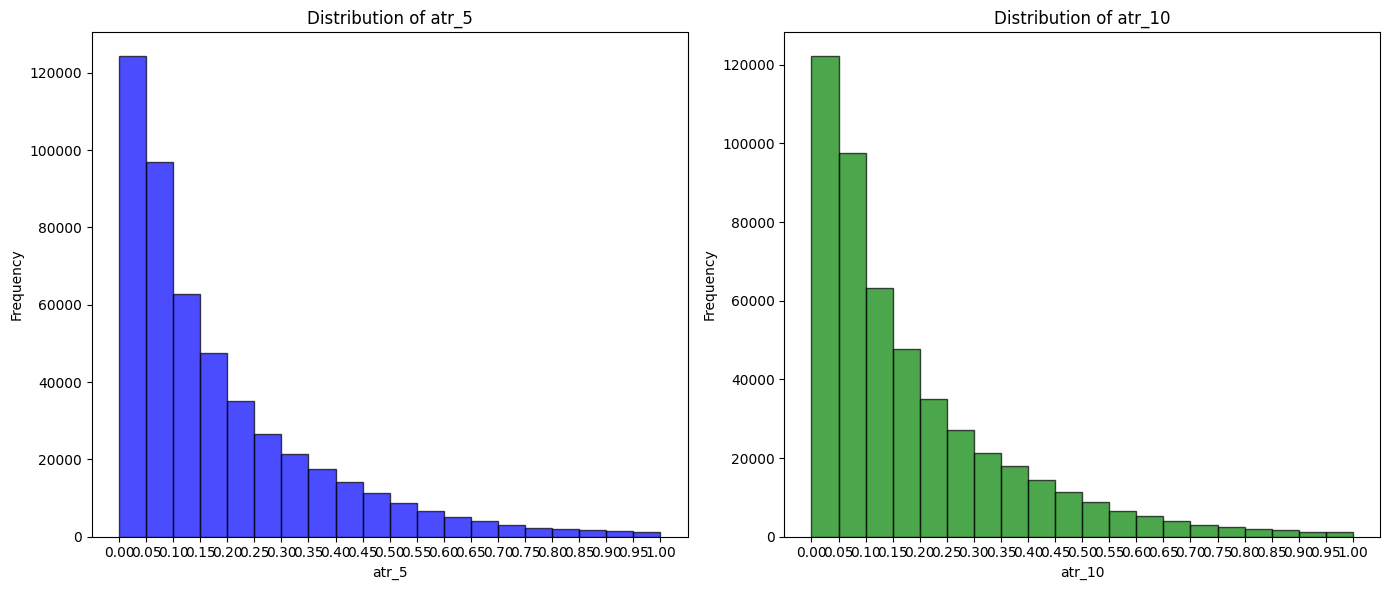

In [26]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'atr_5' and 'atr_10' with X-axis range 0 to 1 and intervals of 0.05
plt.figure(figsize=(14, 6))

# Distribution of atr_5
plt.subplot(1, 2, 1)
plt.hist(filtered_df['atr_5'], bins=np.arange(0, 1.05, 0.05), color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of atr_5')
plt.xlabel('atr_5')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.05, 0.05))

# Distribution of atr_10
plt.subplot(1, 2, 2)
plt.hist(filtered_df['atr_10'], bins=np.arange(0, 1.05, 0.05), color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of atr_10')
plt.xlabel('atr_10')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.05, 0.05))

plt.tight_layout()
plt.show()

In [27]:
# Calculating the percentage of values in each 0.05 interval for 'atr_5' and 'atr_10'
bins = np.arange(0, 1.05, 0.05)
atr_5_counts, _ = np.histogram(filtered_df['atr_5'], bins=bins)
atr_10_counts, _ = np.histogram(filtered_df['atr_10'], bins=bins)

# Calculate the percentage
atr_5_percentage = atr_5_counts / len(filtered_df) * 100
atr_10_percentage = atr_10_counts / len(filtered_df) * 100

# Create a DataFrame to display the results
percentage_df = pd.DataFrame({
    'Bin': [f'{bins[i]} - {bins[i+1]}' for i in range(len(bins)-1)],
    'atr_5_percentage': atr_5_percentage,
    'atr_10_percentage': atr_10_percentage
})

percentage_df

,Bin,atr_5_percentage,atr_10_percentage
0,0.0 - 0.05,24.869790,24.446833
1,0.05 - 0.1,19.375553,19.510066
2,0.1 - 0.15000000000000002,12.585022,12.656882
3,0.15000000000000002 - 0.2,9.486607,9.556466
4,0.2 - 0.25,7.004712,7.027131
5,0.25 - 0.30000000000000004,5.335703,5.453403
6,0.30000000000000004 - 0.35000000000000003,4.303432,4.269804
7,0.35000000000000003 - 0.4,3.496351,3.594434
8,0.4 - 0.45,2.850406,2.898847
9,0.45 - 0.5,2.252101,2.295938


In [5]:
# open_time 열이 datetime 형식이 아닌 경우 변환
if not np.issubdtype(data['open_time'].dtype, np.datetime64):
    data['open_time'] = pd.to_datetime(data['open_time'])

# time 열을 분 단위로 변환
data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

# 사용하지 않을 열 제외
data = data.drop(columns=['open_time'])

# 목표 변수 생성 (max_return_60min이 1.1% 이상인 경우 1, 그렇지 않으면 0)
data['target'] = (data['max_return_60min'] >= 1.1).astype(int)

# 특성과 목표 변수 분리
X = data.drop(columns=['max_return_60min', 'min_return_60min', 'target'])
y = data['target']

# 데이터 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 시계열 데이터 생성 함수
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 데이터 샘플링으로 메모리 사용 줄이기
sample_size = 10000  # 샘플링할 데이터 크기
sample_indices = np.random.choice(len(X_scaled) - 60, sample_size, replace=False)

X_sampled = []
y_sampled = []

for idx in sample_indices:
    X_sampled.append(X_scaled[idx:idx + 60])
    y_sampled.append(y[idx + 60])

X_sampled = np.array(X_sampled)
y_sampled = np.array(y_sampled)

# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 60, 63)
X_test shape: (2000, 60, 63)
y_train shape: (8000,)
y_test shape: (2000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])


In [ ]:
# 예측 및 평가
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [ ]:
# SHAP 값 계산
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# SHAP 값 시각화
shap.summary_plot(shap_values, X_test, feature_names=X.columns)